In [66]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx


import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import KBinsDiscretizer
import plotly.express as px

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster,HeatMap,HeatMapWithTime
import branca.colormap as colormap
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import geopandas as gpd
from shapely.geometry import Point

# GNN Model

In [48]:
json_file_path = "Countries/nodes_and_links_countries.json"

with open(json_file_path, 'r') as j:
     jdict = json.loads(j.read())
     
path = "Countries/countries of the world.csv"
df_gdp = pd.read_csv(path,decimal=',')

In [49]:
df_gdp['Country'] = df_gdp['Country'].map(lambda x: str(x)[:-1])

correspondence = {
   'Micronesia, Fed. St.':'Federated States of Micronesia',
   'Antigua & Barbuda':'Antigua and Barbuda',
   'Bahamas, The':'Bahamas',
   'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
   'Trinidad & Tobago':'Trinidad and Tobago',
   'Central African Rep.': 'Central African Republic',
   'Congo, Dem. Rep.':'Democratic Republic of the Congo',
   'Congo, Repub. of the':'Republic of the Congo',
   "Cote d'Ivoire": "Côte d'Ivoire",
   'Gambia, The': 'The Gambia',
   'Sao Tome & Principe':'São Tomé and Príncipe',
   'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
   'Macedonia':'North Macedonia',
   'China': "People's Republic of China",
   'Korea, North':'North Korea',
   'Korea, South':'South Korea',
   'Burma':'Myanmar'
    }

df_gdp = df_gdp.replace({"Country": correspondence})

countries_df = df_gdp['Country'].values
countries_nodes = ([node['name'] for node in jdict['nodes']])

mismatch = [i for i in countries_nodes if i not in countries_df]
nodes = set(countries_nodes)-set(mismatch)
nodes_df = [i for i in nodes]

df = df_gdp[df_gdp['Country'].isin(nodes_df)]

df.drop(['Region'], axis=1, inplace=True)

In [50]:
df_filtered = df.copy()
df_filtered['Infant mortality (per 1000 births)'] = df['Infant mortality (per 1000 births)'].apply(np.log10)
df_filtered['GDP ($ per capita)'] = df['GDP ($ per capita)'].apply(np.log10)
df_filtered['Phones (per 1000)'] = df['Phones (per 1000)'].apply(np.log10)
df_filtered['Pop. Density (per sq. mi.)'] = df['Pop. Density (per sq. mi.)'].apply(np.log10)
df_filtered['Other (%)'] = df['Other (%)'].apply(np.sqrt)
df_filtered['Literacy (%)'] = df['Literacy (%)'].apply(np.sqrt)

In [51]:
df_test = df_filtered.copy()

class_values = sorted(df_test["Country"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}

df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])

df_test=df_test.dropna()

df_test['GDP'] =df_test['GDP ($ per capita)']

df_test.drop(['GDP ($ per capita)'], axis=1, inplace=True)

In [52]:
existing_countries = df_test.Country.to_list()

edges = []
for n in jdict['links']:
    if (n['source'] in existing_countries) and (n['target'] in existing_countries):
        edges.append((n['source'], n['target']))
        
df_edges= pd.DataFrame.from_records(edges, columns =['source', 'target'])

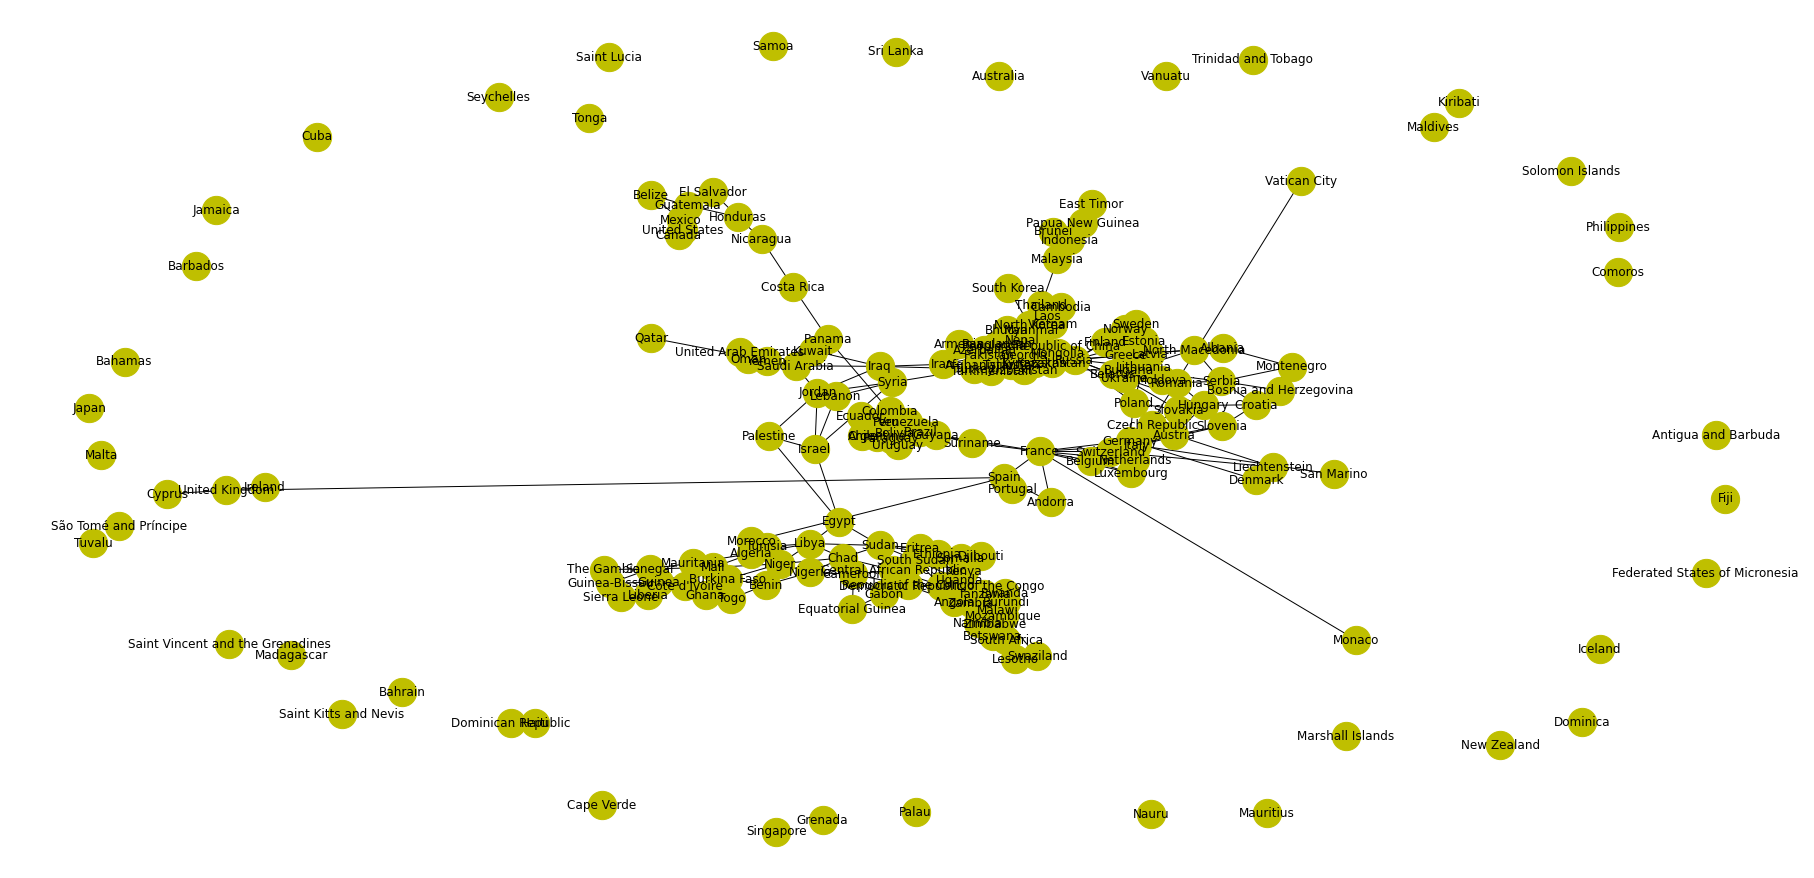

In [53]:
G = nx.Graph()
G.add_nodes_from([node['name'] for node in jdict['nodes']])
G.add_weighted_edges_from([(edge['source'], edge['target'], edge['border'])
                  for edge in jdict['links']])

pos = nx.spring_layout(G, k=.6)
plt.figure(figsize=(25,12))
nx.draw(G, 
        pos=pos,
        node_size=800, 
        with_labels=True, 
        node_color='y')
plt.show()

In [54]:
class_values = sorted(df_test["Country"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}

df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])

df_edges["source"] = df_edges["source"].apply(lambda name: class_idx[name])
df_edges["target"] = df_edges["target"].apply(lambda name: class_idx[name])

In [55]:
feature_names = set(df_test.columns) - {"Country", "GDP", 'Country ID'}
num_features = len(feature_names)
num_classes = num_features

In [56]:
train_data, test_data = [], []

for _, group_data in df_test.groupby("GDP"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

y_train = train_data["GDP"]
y_test = test_data["GDP"]

In [57]:
DROPOUT_RATE  =0.2

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(1e-1),
        loss='mse',
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="loss", patience=50, restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=5000,
        batch_size=2048,
        validation_split=0.2,
        callbacks=[early_stopping],

    )

    return history

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=DROPOUT_RATE,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]
        aggregated_message = tf.math.unsorted_segment_mean(
            neighbour_messages, node_indices, num_segments=num_nodes
        )
        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        node_embeddings = self.update_fn(h)
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        return self.update(node_repesentations, aggregated_messages)

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=DROPOUT_RATE,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

In [58]:
edges = df_edges[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    df_test.sort_values("Country")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

graph_info = (node_features, edges, edge_weights)

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[32, 32],
    dropout_rate=DROPOUT_RATE,
    name="gnn_model",
)

In [59]:
gnn_model([1,10])

<tf.Tensor: shape=(2, 17), dtype=float32, numpy=
array([[ 190809.78  ,  -23312.527 ,  259196.5   , -186045.97  ,
         -34434.094 ,  -72521.055 ,  -19060.781 ,  -15530.359 ,
         -33450.766 ,   23648.094 , -375272.78  ,  210773.66  ,
         -73959.836 ,  -75714.67  ,  133829.16  , -142870.56  ,
          12587.546 ],
       [  37277.125 ,   -4435.7637,   50418.543 ,  -36102.17  ,
          -6860.017 ,  -13908.302 ,   -3713.0273,   -2943.3623,
          -6576.4844,    4864.3926,  -73112.98  ,   41260.66  ,
         -14315.426 ,  -14640.277 ,   26398.025 ,  -27786.719 ,
           2601.4126]], dtype=float32)>

In [61]:
x_train = train_data['Country ID'].to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/5000
1/1 [==============================] - 4s 4s/step - loss: 14.2537 - val_loss: 252.7631
Epoch 2/5000
1/1 [==============================] - 0s 35ms/step - loss: 6.6605 - val_loss: 377.0218
Epoch 3/5000
1/1 [==============================] - 0s 45ms/step - loss: 5.7029 - val_loss: 352.6204
Epoch 4/5000
1/1 [==============================] - 0s 39ms/step - loss: 1.7417 - val_loss: 119.5623
Epoch 5/5000
1/1 [==============================] - 0s 30ms/step - loss: 3.0179 - val_loss: 183.6698
Epoch 6/5000
1/1 [==============================] - 0s 42ms/step - loss: 1.6801 - val_loss: 522.3856
Epoch 7/5000
1/1 [==============================] - 0s 33ms/step - loss: 2.4480 - val_loss: 364.0838
Epoch 8/5000
1/1 [==============================] - 0s 40ms/step - loss: 0.9819 - val_loss: 307.5833
Epoch 9/5000
1/1 [==============================] - 0s 30ms/step - loss: 1.3299 - val_loss: 443.9373
Epoch 10/5000
1/1 [==============================] - 0s 32ms/step - loss: 1.0436 - val_loss:

In [63]:
x_test = test_data['Country ID'].to_numpy()

mse_train = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
mse_test = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)

print(np.sqrt(mse_train), np.sqrt(mse_test))

0.2519001868175739 0.24482167428653132


# RNN

In [67]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

RANDOM_SEED = 42
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [68]:
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)


In [74]:
df_latlong = pd.read_csv('countries.csv')
df_latlong.drop(['Importance', 'Altitude'], axis=1, inplace=True)

df_gdp = pd.read_csv('gdp_per_capita.csv')
df_gdp.drop(['Unnamed: 65', 'Code'], axis=1, inplace=True)

countries_df_latlong = df_latlong['Country'].values
countries_df_gdp = df_gdp['Country Name'].values

mismatch = [i for i in countries_df_latlong if i not in countries_df_gdp]

nodes = set(countries_df_latlong)-set(mismatch)
nodes_df = [i for i in nodes]

df = df_latlong[df_latlong['Country'].isin(nodes_df)]

df = pd.merge(df_latlong,df_gdp,how='inner',left_on=['Country'],right_on=['Country Name'])

df.drop(['Country Name'], axis=1, inplace=True)

df = df.rename({'Latitude': 'Lat', 'Longitude': 'Lon'}, axis=1)

GDP_years = list(set(df.columns) - {'Country', 'Lat', 'Lon'})

for column in GDP_years:
    df[column] = np.log10(df[column])

df = df.melt(id_vars=['Country', 'Lat', 'Lon'], 
        var_name="Year", 
        value_name="GDP")

data = df.copy()

In [76]:
del df['geometry']

colunas = df.columns.tolist()

lista_unica = unique(df['Country'].tolist())

dataset = []

for pais in lista_unica:
   data_pais = df[df["Country"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   linha = 0
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
 
   while linha<len(gdp)-3:
    
     gdp_1 = gdp[linha]
     gdp_2 = gdp[linha+1]
     gdp_3 = gdp[linha+2]
     gdp_4 = gdp[linha+3]
     gdp_5 = gdp[linha+4]
     if math.isnan(gdp_1) or math.isnan(gdp_2) or math.isnan(gdp_3) or math.isnan(gdp_4) or math.isnan(gdp_5):
       nan = 0
     else:
       dataset.append([latitude_pais, longitude_pais, gdp_1, gdp_2, gdp_3, gdp_4, gdp_5])

     linha +=4


In [77]:
my_array = np.array(dataset)
dataset = my_array.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [79]:
n_steps = 6

setenta_porc= int((70*len(dataset))/100)
vint_poc = int((20*len(dataset))/100)
nov_porc=setenta_porc+vint_poc

X_train, y_train = dataset[:setenta_porc, :n_steps], dataset[:setenta_porc, -1]
X_valid, y_valid = dataset[setenta_porc:nov_porc, :n_steps], dataset[setenta_porc:nov_porc, -1]
X_test, y_test = dataset[nov_porc:, :n_steps], dataset[nov_porc:, -1]

y_pred = X_valid[:, -1]

In [80]:
X_train = X_train.reshape((1332,1,6))
X_valid = X_valid.reshape((380,1,6))

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)

history = model.fit(
    X_train,
    y_train,
    epochs=20, #20
    batch_size=180, #180
    validation_data=(X_valid, y_valid),
)

Epoch 1/20
8/8 [==============================] - 1s 29ms/step - loss: 0.3654 - val_loss: 0.2334
Epoch 2/20
8/8 [==============================] - 0s 4ms/step - loss: 0.1226 - val_loss: 0.0643
Epoch 3/20
8/8 [==============================] - 0s 6ms/step - loss: 0.0400 - val_loss: 0.0227
Epoch 4/20
8/8 [==============================] - 0s 6ms/step - loss: 0.0283 - val_loss: 0.0183
Epoch 5/20
8/8 [==============================] - 0s 6ms/step - loss: 0.0297 - val_loss: 0.0186
Epoch 6/20
8/8 [==============================] - 0s 6ms/step - loss: 0.0296 - val_loss: 0.0177
Epoch 7/20
8/8 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0166
Epoch 8/20
8/8 [==============================] - 0s 5ms/step - loss: 0.0252 - val_loss: 0.0164
Epoch 9/20
8/8 [==============================] - 0s 5ms/step - loss: 0.0235 - val_loss: 0.0165
Epoch 10/20
8/8 [==============================] - 0s 5ms/step - loss: 0.0225 - val_loss: 0.0164
Epoch 11/20
8/8 [=====================

In [81]:
model.evaluate(X_valid, y_valid)

y_pred = model.predict(X_valid)

12/12 [==============================] - 0s 1ms/step


# Join Datasets and Predictions